#**INSTALLING PACKAGE**

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.8 MB/s 
     |████████████████████████████████| 1.6 MB 33.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras_tuner.tuners import RandomSearch

#**PREPARING DATA**

In [ ]:
def preparingData():
    df_raw = pd.read_excel("data.xlsx")
    df = df_raw[["delta pressure","Leak rate (STB/d)","leak_location"]]
    return df 

In [ ]:
df = preparingData()

In [ ]:
df.head()

,delta pressure,Leak rate (STB/d),leak_location
0,186.5110,280,200
1,186.5202,280,400
2,186.5295,280,600
3,186.5388,280,800
4,186.5473,280,1000


#**PREPROCESSING DATA**

In [ ]:
def preprocessingData(df):
    X = df.iloc[:,:2]       # x disini sebagai input yaitu leak rate ,
        # mengambil iloc[baris,kolom] = [:,:2] yaitu data pada semua baris di kolom 0,1
    y = df["leak_location"] # y disini sebagai input yaitu leak_location
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)
    return X_train, X_test, y_train,y_test

In [ ]:
X_train, X_test, y_train,y_test = preprocessingData(df)

In [ ]:
print(f'Jumlah x_train : {len(X_train)}')
print(f'Jumlah y_train : {len(y_train)}')
print()
print(f'Jumlah x_test : {len(X_test)}')
print(f'Jumlah y_test : {len(y_test)}')

Jumlah x_train : 1596
Jumlah y_train : 1596

Jumlah x_test : 399
Jumlah y_test : 399


#**BASELINE ANALYSIS MODEL**

In [ ]:
def createFeaturesScallingLayer(X_train):
    normalize = layers.Normalization()
    normalize.adapt(X_train)
    return normalize

In [ ]:
normalize = createFeaturesScallingLayer(X_train)

In [ ]:
# membuat deep learning nya
def baselineANN():
    model = keras.Sequential() # layer ditambahkan manual satu per satu 
    model.add(layers.InputLayer(input_shape = (2,))) 
    # 2 karena kita diatas hanya pakai 2 input yaitu delta pressure dan Leak rate (STB/d)
    model.add(normalize) # menormalisasikan agar performa lebih baik dan komputasi lebih cepat
    model.add(layers.Dense(64,activation="relu"))   #layer tersembunyi pertama dengan 64 neuron
    model.add(layers.Dense(64,activation="relu"))   #layer tersembunyi kedua debagb 64 neuron
    model.add(layers.Dense(1,name="output_layer"))  # 1 output layer dengan 1 neuron

    model.compile(loss="mean_absolute_error", 
                  optimizer=keras.optimizers.Adam(),
                  metrics = ["mean_absolute_error"]) # untuk nampilin hasil mean absolute error
    return model

In [ ]:
baselineModel = baselineANN()

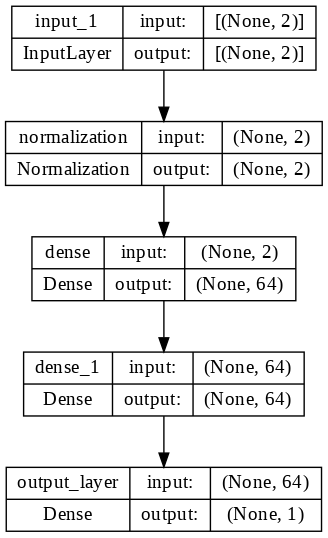

In [ ]:
plot_model(baselineModel,show_shapes=True,dpi=100, show_layer_names=True)

Model baseline di-training dengan data training sebanyak 200 epochs. Kemudian, dilakukan evaluasi model menggunakan data testing dan dihasilkan error yang semakin lama semakin mengecil seperti pada plot. 

In [ ]:
def trainModel(model,X_train,y_train):
    history = model.fit(X_train,y_train, epochs=200,steps_per_epoch=25, validation_split = 0.2, verbose = 0)
    return history

In [ ]:
history = trainModel(baselineModel, X_train, y_train)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error[Leak location]')
    plt.legend()
    plt.grid(True)

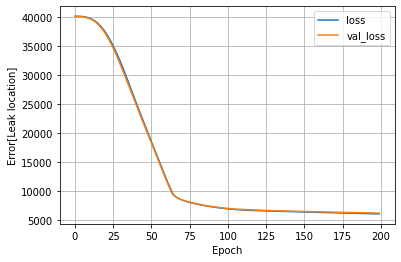

In [ ]:
plot_loss(history)

In [ ]:
def plot_predVStrue(model,X,y):
    predictions = model.predict(X).flatten()
    a = plt.axes(aspect='equal')
    plt.scatter(predictions,y)
    plt.xlabel('True Values [Leak location]')
    plt.ylabel('Predictions [Leak location]')
    lims = [0,80000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims,lims,color='red')


13/13 [==============================] - 0s 2ms/step


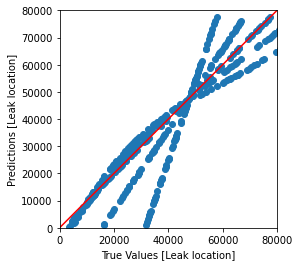

In [ ]:
plot_predVStrue(baselineModel,X_test, y_test)

In [ ]:
def plot_perLeakRate(model,X,y):
    idx = X.index[X['Leak rate (STB/d)'] == 280].tolist()
    d_280 = X.loc[idx]
    pred_280 = model.predict(d_280)
    sim_280 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 560].tolist()
    d_560 = X.loc[idx]
    pred_560 = model.predict(d_560)
    sim_560 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 840].tolist()
    d_840 = X.loc[idx]
    pred_840 = model.predict(d_840)
    sim_840 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 1120].tolist()
    d_1120 = X.loc[idx]
    pred_1120 = model.predict(d_1120)
    sim_1120 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 1400].tolist()
    d_1400 = X.loc[idx]
    pred_1400 = model.predict(d_1400)
    sim_1400 = y.loc[idx]

    fig,axs = plt.subplots(2, 3, figsize = (15,10))
    axs[0,0].plot( sim_280, sim_280, color='red')
    axs[0,0].scatter(pred_280, sim_280, color='blue')
    axs[0,0].set_title('Rate 280 STB/D')

    axs[0,1].plot( sim_560, sim_560, color='red')
    axs[0,1].scatter(pred_560, sim_560, color='orange')
    axs[0,1].set_title('Rate 560 STB/D')

    axs[0,2].plot( sim_840, sim_840, color='red')
    axs[0,2].scatter(pred_840, sim_840, color='green')
    axs[0,2].set_title('Rate 840 STB/D')

    axs[1,0].plot( sim_1120, sim_1120, color='red')
    axs[1,0].scatter(pred_1120, sim_1120, color='purple')
    axs[1,0].set_title('Rate 1120 STB/D')

    axs[1,1].plot( sim_1400, sim_1400, color='red')
    axs[1,1].scatter(pred_1400, sim_1400, color='brown')
    axs[1,1].set_title('Rate 1400 STB/D')

    for ax in axs.flat:
        ax.set(xlabel='prediction', ylabel='simulation')

3/3 [==============================] - 0s 3ms/step


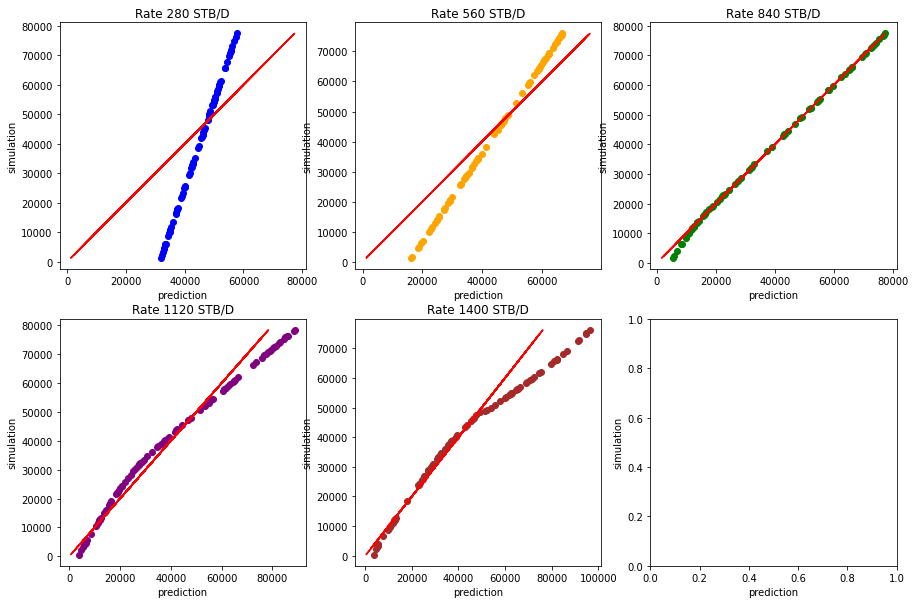

In [ ]:
plot_perLeakRate(baselineModel,X_test,y_test)

In [ ]:
def evaluate(model,X_train,X_test, y_train, y_test):
    print(f'Mean absolute error for train data {mean_absolute_error(y_train,model.predict(X_train)) :.5f}')
    print(f'Mean absolute error for test data {mean_absolute_error(y_test,model.predict(X_test)) :.5f}')

In [ ]:
evaluate(baselineModel, X_train, X_test, y_train, y_test)

50/50 [==============================] - 0s 936us/step
Mean absolute error for train data 6146.80757
13/13 [==============================] - 0s 1ms/step
Mean absolute error for test data 5878.96977


In [ ]:
X_test.head()

,delta pressure,Leak rate (STB/d)
1738,178.6203,1400
1015,185.2102,840
589,186.3532,560
957,183.6321,840
828,180.1247,840


In [ ]:
baselineModel.predict(X_test)

#**HYPERPARAMETER TUNING**

##**2 Layers**

In [ ]:
def build_model_2(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range (0,2):
        optimized_model.add(layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=512,step=32), 
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer2(X_train, y_train):
    tuner2 = RandomSearch(build_model_2,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 2 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner2.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner2

In [ ]:
%%time
tuner2 = layer2(X_train, y_train)

Trial 10 Complete [00h 00m 25s]
val_mean_absolute_error: 1218.6195068359375

Best val_mean_absolute_error So Far: 482.56646728515625
Total elapsed time: 00h 06m 45s
CPU times: user 4min 47s, sys: 24.8 s, total: 5min 12s
Wall time: 6min 45s


In [ ]:
def printBestHps(layers,tuner):
    best_hps = tuner.get_best_hyperparameters(1)[0]
    for i in range(layers):
        print(f'units_{i}:', best_hps.get(f"units_{i}"))
    print('learning_rate:', best_hps.get('learning_rate'))

In [ ]:
printBestHps(2,tuner2)

units_0: 352
units_1: 224
learning_rate: 0.01


#**Best Model**

In [ ]:
def bestModel(tuner):
    model = tuner.get_best_models()[0]
    return model

In [ ]:
best_2layers = bestModel(tuner2)

NameError: ignored

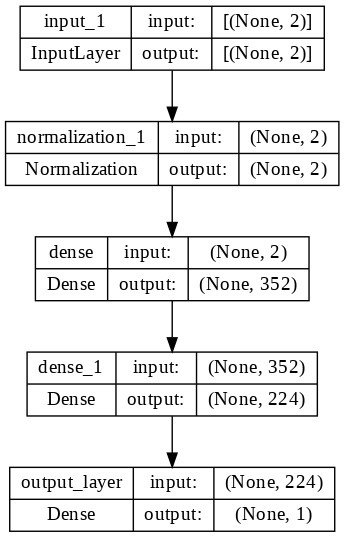

In [ ]:
plot_model(best_2layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_2layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 1ms/step
Mean absolute error for train data 496.57321
13/13 [==============================] - 0s 2ms/step
Mean absolute error for test data 471.09497


In [ ]:
def saveModel(model,layer):
    model.save('model_' + str(layer) + layer.h5)

In [ ]:
plot

In [ ]:
saveModel(best_2layers,2)

NameError: ignored

##**3 Layers**

In [ ]:
def build_model_3(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range (0,3):
        optimized_model.add(layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=512,step=32), 
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer3(X_train, y_train):
    tuner3 = RandomSearch(build_model_3,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 3 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner3.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner3

In [ ]:
%%time
tuner3 = layer3(X_train, y_train)

Trial 10 Complete [00h 00m 42s]
val_mean_absolute_error: 125.52555084228516

Best val_mean_absolute_error So Far: 84.88787841796875
Total elapsed time: 00h 07m 24s
CPU times: user 5min 48s, sys: 30.1 s, total: 6min 18s
Wall time: 7min 23s


In [ ]:
printBestHps(3,tuner3)

IndexError: ignored

#**4 Layers**

In [ ]:
def build_model_4(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range (0,4):
        optimized_model.add(layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=512,step=32), 
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer4(X_train, y_train):
    tuner4 = RandomSearch(build_model_4,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 3 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner4.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner4

In [ ]:
%%time
tuner3 = layer3(X_train, y_train)